<a href="https://colab.research.google.com/github/Emekaborisama/forcasting-with-fb-prophet.ipynb/blob/main/forcasting_with_fb_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/My Drive/Tweet_summarization")

In [ ]:
pip install fbprophet

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
df = pd.read_csv('USvideos3.csv')

In [ ]:
df['publish_time'] = pd.to_datetime(df['publish_time'])

In [ ]:
df['publish_time'] = df['publish_time'].dt.normalize()

In [ ]:
df = df[['publish_time', 'views']]

In [ ]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [ ]:
df['publish_time'] = df['publish_time'].dt.tz_localize(None)


In [ ]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

plotly_df(df, title='Posts on Medium (daily)')

In [ ]:
df1 = {}
df1['ds'] = df['publish_time']
df1['y'] = df['views']
df1 = pd.DataFrame(df1)
df1

ds         y
0     2017-11-13    748374
1     2017-11-13   2418783
2     2017-11-12   3191434
3     2017-11-13    343168
4     2017-11-12   2095731
...          ...       ...
40944 2018-05-18   1685609
40945 2018-05-18   1064798
40946 2018-05-18   1066451
40947 2018-05-17   5660813
40948 2018-05-17  10306119

[40949 rows x 2 columns]

In [ ]:
prediction_size = 70
train = df1[:-prediction_size]
df1.tail(n=3)


ds         y
40946 2018-05-18   1066451
40947 2018-05-17   5660813
40948 2018-05-17  10306119

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

ds
40946 2018-08-21
40947 2018-08-22
40948 2018-08-23

In [ ]:
forecast = m.predict(future)
forecast.tail(n=3)

ds         trend  ...  multiplicative_terms_upper          yhat
40946 2018-08-21  1.992345e+06  ...                         0.0 -1.304508e+06
40947 2018-08-22  1.993906e+06  ...                         0.0 -1.272670e+06
40948 2018-08-23  1.995467e+06  ...                         0.0 -1.174213e+06

[3 rows x 19 columns]

In [ ]:
m.plot(forecast);

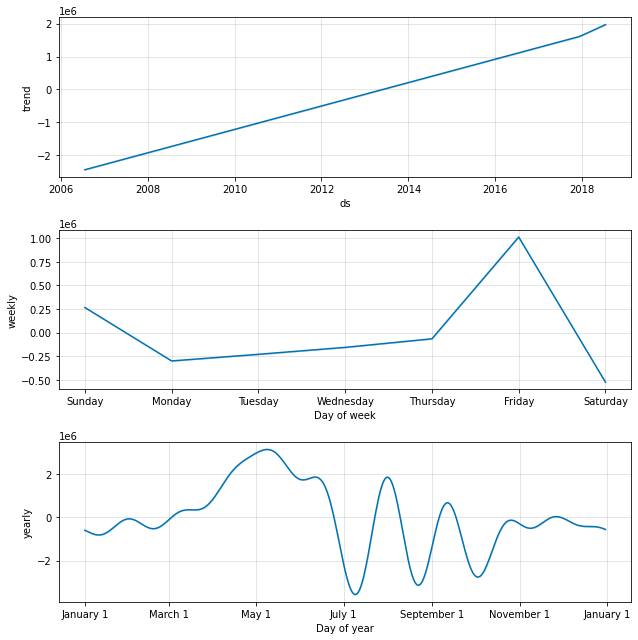

In [ ]:
m.plot_components(forecast);

In [ ]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [ ]:
cmp_df = make_comparison_dataframe(df1, forecast)
cmp_df.tail(n=3)

yhat    yhat_lower    yhat_upper   y
ds                                                      
2018-07-12 -1.483100e+06 -1.057959e+07  7.455273e+06 NaN
2018-07-13 -2.482357e+05 -9.652017e+06  8.612253e+06 NaN
2018-07-14 -1.580722e+06 -1.122930e+07  7.745587e+06 NaN

In [ ]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [ ]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

In [ ]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'New posts on Medium')